In [1]:
%load_ext autoreload
%autoreload 2

### 1. Dependencies

In [2]:
import os
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from loguru import logger
import numpy as np
import shap
print(f'Current working directory: {os.getcwd()}')
# change directory
os.chdir('../')
print(f'New working directory: {os.getcwd()}')

Current working directory: c:\Users\tolayi1\Documents\GitHub\compositional_model\notebooks
New working directory: c:\Users\tolayi1\Documents\GitHub\compositional_model


In [3]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [4]:
# special python class
from source.dataPreprocessing import Data
from source.plotters import Plotters

## 2. Model

### 2.1 Source 

In [5]:
random_state = 42
id = './data/processed/2024-02-15-simulated_data_Ecell_Concentrtn_no_membrane_info_CASE_3-speed-up.csv'
sim_data = pd.read_csv(f'{id}')
sim_data = sim_data.sample(frac=1, random_state=random_state).reset_index(drop=True)
print(sim_data.shape)
sim_data.head()

(5982, 12)


,Ecell,Dil,Conc,Ncell,T_tot,IEC_r,poros_r,dens_r,dp,SR,EC,TEE
0,0.4,3.5,2.5,1,90.0,0.57,0.243,1.404,0.57,0.223286,0.173201,0.471689
1,0.4,5.0,5.0,10,30.0,0.77,0.238,1.442,0.57,0.556324,0.201865,0.463743
2,0.4,3.5,1.0,3,90.0,0.77,0.238,1.442,0.57,0.545219,0.176736,0.415796
3,0.1,2.5,2.5,7,60.0,1.05,0.130,1.276,0.57,0.276799,0.054217,0.487327
4,2.0,1.0,3.5,1,90.0,0.77,0.238,1.442,0.57,0.786540,0.919414,0.492563


In [6]:
sim_data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Ecell,5982.0,0.900502,0.722067,0.100000,0.400000,1.000000,2.000000,2.000000
Dil,5982.0,3.062423,1.432218,1.000000,2.500000,3.500000,5.000000,5.000000
Conc,5982.0,2.959502,1.453646,1.000000,1.000000,2.500000,3.500000,5.000000
Ncell,5982.0,5.243731,3.483706,1.000000,3.000000,4.000000,7.000000,10.000000
T_tot,5982.0,75.000000,33.600971,15.000000,45.000000,75.000000,105.000000,165.000000
IEC_r,5982.0,0.645961,0.322268,0.000000,0.570000,0.770000,0.790000,1.050000
poros_r,5982.0,0.343001,0.296322,0.130000,0.186000,0.238000,0.265000,1.000000
dens_r,5982.0,1.140582,0.511157,0.000000,1.276000,1.348000,1.404000,1.442000
dp,5982.0,0.475476,0.212017,0.000000,0.570000,0.570000,0.570000,0.570000
SR,5982.0,0.589342,0.313013,0.008700,0.289214,0.632732,0.899906,0.995827


In [7]:
desire_columns = sim_data.columns
desire_columns

Index(['Ecell', 'Dil', 'Conc', 'Ncell', 'T_tot', 'IEC_r', 'poros_r', 'dens_r',
       'dp', 'SR', 'EC', 'TEE'],
      dtype='object')

In [8]:
random_seed = 104 #np.random.randint(0, 1000)
logger.info(f'Random seed: {random_seed}')
train_size, test_size, val_size = 0.8, 0.15, 0.05
DataProcess = Data(data=sim_data, target_column=['SR', 'EC', 'TEE'], 
                   test_size=test_size, val_size=val_size, random_seed=random_seed,
                   scaler_name='source_EOS_R2')
X_train, X_test, X_val, y_train, y_test, y_val = DataProcess.preprocess(save_scaler=True)

2024-09-03 13:47:11.312 | INFO     | __main__:<module>:2 - Random seed: 104
2024-09-03 13:47:11.314 | INFO     | source.dataPreprocessing:preprocess:37 - mean of Y: 0.4977447030521021
2024-09-03 13:47:11.314 | INFO     | source.dataPreprocessing:preprocess:39 - Initiated Standardizing data
2024-09-03 13:47:11.317 | SUCCESS  | source.dataPreprocessing:preprocess:51 - Standardizing completed
2024-09-03 13:47:11.317 | INFO     | source.dataPreprocessing:preprocess:54 - Initiated train-test split for model evaluation and validation
2024-09-03 13:47:11.319 | SUCCESS  | source.dataPreprocessing:preprocess:59 - Train: ((4785, 9), (4785, 3)) --> 79.99%
2024-09-03 13:47:11.319 | SUCCESS  | source.dataPreprocessing:preprocess:60 - Val: ((898, 9), (898, 3)) --> 15.01%
2024-09-03 13:47:11.320 | SUCCESS  | source.dataPreprocessing:preprocess:61 - Test: ((299, 9), (299, 3)) --> 5.00%
2024-09-03 13:47:11.320 | SUCCESS  | source.dataPreprocessing:preprocess:63 - train-test split completed


In [9]:
print(X_train.shape, X_test.shape, X_val.shape, y_train.shape, y_test.shape, y_val.shape)

(4785, 9) (299, 9) (898, 9) (4785, 3) (299, 3) (898, 3)


In [10]:
source_model_name= './models/2024-02-20_source_model_approach_R2.h5'
target_model_name= './models/2024-02-20_target_model_approach_R2.h5'

In [11]:
!ls -lrt {source_model_name}
!ls -lrt {target_model_name}

-rw-r--r-- 1 tolayi1 domain users 43344 Feb 20  2024 ./models/2024-02-20_source_model_approach_R2.h5
-rw-r--r-- 1 tolayi1 domain users 42596 Feb 20  2024 ./models/2024-02-20_target_model_approach_R2.h5


In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow import keras
import tensorflow as tf
from keras import backend as K

# coefficient of determination (R^2) for regression
def r_square(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return (1 - SS_res/(SS_tot + K.epsilon()))

# root mean squared error (rmse) for regression
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1))

def source_model():
    # {'num_layers': 4, 'learning_rate': 0.001, 
    # 'units_0': 50, 'units_1': 42, 'units_2': 29, 'units_3': 50}
    model = Sequential()
    model.add(keras.layers.Dense(50, activation='relu'))
    model.add(keras.layers.Dense(42, activation='relu'))
    model.add(keras.layers.Dense(29, activation='relu'))
    model.add(keras.layers.Dense(50, activation='relu'))
    model.add(keras.layers.Dense(3, activation='linear'))

    model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=1e-2),
            loss="mean_squared_error", metrics=["mean_squared_error", rmse, r_square])
    
    return model


In [13]:
# create dummy data with shape (10, 9) and (10, 3)
X = np.random.rand(10, 9) 
y = np.random.rand(10, 3)
# Create a new model for transfer learning
SourceModel = source_model()
# fit the model
history = SourceModel.fit(X, y, epochs=1, verbose=1)
# Load the weights of the trained model
SourceModel.load_weights(f'{source_model_name}')
SourceModel.summary()

1/1 [==============================] - 1s 628ms/step - loss: 0.3572 - mean_squared_error: 0.3572 - rmse: 0.5931 - r_square: -4.4418
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 50)                500       
                                                                 
 dense_1 (Dense)             (None, 42)                2142      
                                                                 
 dense_2 (Dense)             (None, 29)                1247      
                                                                 
 dense_3 (Dense)             (None, 50)                1500      
                                                                 
 dense_4 (Dense)             (None, 3)                 153       
                                                                 
Total params: 5542 (21.65 KB)
Trainable params: 5542 (21

In [14]:
train_predictions = SourceModel.predict(X_train).flatten()
val_predictions = SourceModel.predict(X_val).flatten()
test_predictions = SourceModel.predict(X_test).flatten()

# accuracy
print('Training set')
print(f'RMSE: {np.sqrt(mean_squared_error(y_train.flatten(), train_predictions)):0.2f}, R^2: {r2_score(y_train.flatten(), train_predictions):0.2f}, MAE: {mean_absolute_error(y_train.flatten(), train_predictions):0.2f}')
print('Validation set')
print(f'RMSE: {np.sqrt(mean_squared_error(y_val.flatten(), val_predictions)):0.2f}, R^2: {r2_score(y_val.flatten(), val_predictions):0.2f}, MAE: {mean_absolute_error(y_val.flatten(), val_predictions):0.2f}')
print('Test set')
print(f'RMSE: {np.sqrt(mean_squared_error(y_test.flatten(), test_predictions)):0.2f}, R^2: {r2_score(y_test.flatten(), test_predictions):0.2f}, MAE: {mean_absolute_error(y_test.flatten(), test_predictions):0.2f}')


10/10 [==============================] - 0s 556us/step
Training set
RMSE: 0.02, R^2: 0.99, MAE: 0.01
Validation set
RMSE: 0.08, R^2: 0.94, MAE: 0.01
Test set
RMSE: 0.01, R^2: 1.00, MAE: 0.01


In [15]:
SourcePlotter = Plotters()

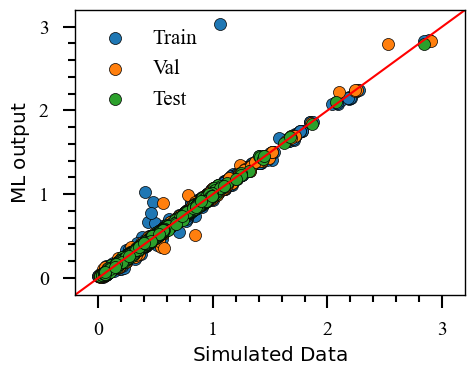

In [16]:
SourcePlotter.plot_model_eval(
            predictions={'train': train_predictions, 'test': test_predictions, 'val': val_predictions},
                        labels={'train': y_train.flatten(), 'test': y_test.flatten(), 'val': y_val.flatten()}, 
                        llimit=-0.2, ulimit=3.2, fig_size=(5, 4),
                        name='source_model_eval', 
                        x_label = r'$\rm Simulated \ Data$',
                        y_label = r'$\rm ML \ output$', save_fig=False, add_legend=True)

In [17]:
(y_train.flatten() - train_predictions).min(), (y_train.flatten() - train_predictions).max()

(-0.1613020899799884, 1.9708728176069563)

In [18]:
(y_test.flatten() - test_predictions).min(), (y_test.flatten() - test_predictions).max()

(-0.04972794635385802, 0.06273608311544043)

In [19]:
(y_val.flatten() - val_predictions).min(), (y_val.flatten() - val_predictions).max()

(-0.3328431860766151, 3.7805236684010968)

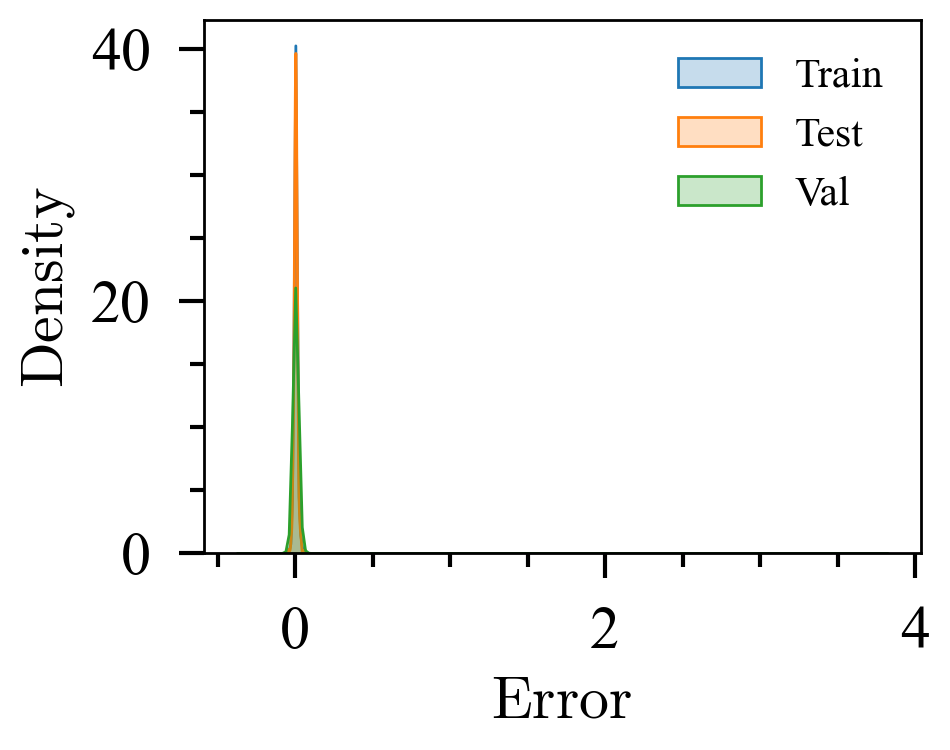

In [20]:
SourcePlotter.plot_pred_distribution(
        error_data={'train': y_train.flatten() - train_predictions,
                    'test': y_test.flatten() - test_predictions,
                    'val': y_val.flatten() - val_predictions},
        fig_size=(5, 4), add_legend=False)

### 2.2 Target

In [21]:
exp_data = pd.read_csv('./data/processed/2023-12-01-experimental-data_Ecell_Concentrtn_no_membrane_info_CASE_3-speed-up.csv')
print(exp_data.shape)
exp_data.head()

(30, 12)


,Ecell,Dil,Conc,Ncell,T_tot,IEC_r,poros_r,dens_r,dp,SR,EC,TEE
0,1,2.641168,2.910681,4,0.25,0.69,0.265,1.348,0.57,0.152863,0.966967,0.498039
1,1,2.641168,2.910681,4,0.75,0.69,0.265,1.348,0.57,0.438058,1.010693,0.482990
2,1,2.641168,2.910681,4,1.25,0.69,0.265,1.348,0.57,0.678199,1.000828,0.451041
3,1,2.641168,2.910681,4,1.75,0.69,0.265,1.348,0.57,0.851402,1.007712,0.400228
4,1,2.641168,2.910681,4,2.75,0.69,0.265,1.348,0.57,0.990605,1.091498,0.251233


In [22]:
# convert time from hours to minutes
exp_data['T_tot'] = exp_data['T_tot'].apply(lambda x: x*60)
exp_data.head()

,Ecell,Dil,Conc,Ncell,T_tot,IEC_r,poros_r,dens_r,dp,SR,EC,TEE
0,1,2.641168,2.910681,4,15.0,0.69,0.265,1.348,0.57,0.152863,0.966967,0.498039
1,1,2.641168,2.910681,4,45.0,0.69,0.265,1.348,0.57,0.438058,1.010693,0.482990
2,1,2.641168,2.910681,4,75.0,0.69,0.265,1.348,0.57,0.678199,1.000828,0.451041
3,1,2.641168,2.910681,4,105.0,0.69,0.265,1.348,0.57,0.851402,1.007712,0.400228
4,1,2.641168,2.910681,4,165.0,0.69,0.265,1.348,0.57,0.990605,1.091498,0.251233


In [23]:
exp_data = exp_data[desire_columns]
exp_data = exp_data.sample(frac=1, random_state=random_state).reset_index(drop=True)
exp_data.head()

,Ecell,Dil,Conc,Ncell,T_tot,IEC_r,poros_r,dens_r,dp,SR,EC,TEE
0,1,2.709363,2.928619,4,75.0,1.05,0.130,1.276,0.57,0.905294,0.987562,0.369784
1,1,2.569995,2.920128,4,15.0,0.77,0.238,1.442,0.57,0.229597,0.932530,0.495569
2,1,2.699749,2.949353,4,105.0,1.05,0.130,1.276,0.57,0.972821,1.018448,0.298879
3,1,2.569995,2.920128,4,75.0,0.77,0.238,1.442,0.57,0.833625,1.050763,0.407786
4,1,2.680549,2.931789,4,105.0,0.69,0.265,1.348,0.57,0.869057,0.967782,0.391345


In [24]:
source_scaler = f"2024-08-22_source_EOS_R2_scaler_seed104_train_size80.0percent"
source_scaler

'2024-08-22_source_EOS_R2_scaler_seed104_train_size80.0percent'

In [25]:
# new data from the same distribution but not imputed
DataProcess_transfer = Data(data=exp_data, target_column=['SR', 'EC', 'TEE'], 
                   test_size=0.15, val_size=0.1, random_seed=104,
                   scaler_name='target_EOS_R2')
X_train_transfer, X_test_transfer, X_val_transfer, y_train_transfer, y_test_transfer, y_val_transfer = DataProcess_transfer.preprocess(load_scaler=True, scaler_path= source_scaler) #f'2024-02-14_source_EOS_scaler_seed{random_seed}_train_size{(1 - test_size - val_size)*100}percent')

2024-09-03 13:47:15.510 | INFO     | source.dataPreprocessing:preprocess:37 - mean of Y: 0.7021420348888888
2024-09-03 13:47:15.511 | INFO     | source.dataPreprocessing:preprocess:39 - Initiated Standardizing data
2024-09-03 13:47:15.512 | SUCCESS  | source.dataPreprocessing:preprocess:51 - Standardizing completed
2024-09-03 13:47:15.513 | INFO     | source.dataPreprocessing:preprocess:54 - Initiated train-test split for model evaluation and validation
2024-09-03 13:47:15.514 | SUCCESS  | source.dataPreprocessing:preprocess:59 - Train: ((22, 9), (22, 3)) --> 73.33%
2024-09-03 13:47:15.514 | SUCCESS  | source.dataPreprocessing:preprocess:60 - Val: ((5, 9), (5, 3)) --> 16.67%
2024-09-03 13:47:15.515 | SUCCESS  | source.dataPreprocessing:preprocess:61 - Test: ((3, 9), (3, 3)) --> 10.00%
2024-09-03 13:47:15.515 | SUCCESS  | source.dataPreprocessing:preprocess:63 - train-test split completed


In [26]:
inputs = keras.Input(shape=(9,)) # X_train_transfer.shape[1] inputs
x = SourceModel(inputs, training=False) # transfer learning; use the trained model and set training to False
outputs = keras.layers.Dense(3)(x) # 3 outputs
TargetModel = keras.Model(inputs, outputs)
TargetModel.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=1e-6),
            loss="mean_squared_error", metrics=["mean_squared_error", rmse, r_square])

In [27]:
# load weights from the saved weights
TargetModel.load_weights('./models/2024-02-20_target_model_approach_R2.h5')

In [28]:
train_predictions_transfer = TargetModel.predict(X_train_transfer).flatten()
val_predictions_transfer = TargetModel.predict(X_val_transfer).flatten()
test_predictions_transfer = TargetModel.predict(X_test_transfer).flatten()

# accuracy
print('Training set')
print(f'RMSE: {np.sqrt(mean_squared_error(y_train_transfer.flatten(), train_predictions_transfer)):0.2f}, R^2: {r2_score(y_train_transfer.flatten(), train_predictions_transfer):0.2f}, MAE: {mean_absolute_error(y_train_transfer.flatten(), train_predictions_transfer):0.2f}')
print('Validation set')
print(f'RMSE: {np.sqrt(mean_squared_error(y_val_transfer.flatten(), val_predictions_transfer)):0.2f}, R^2: {r2_score(y_val_transfer.flatten(), val_predictions_transfer):0.2f}, MAE: {mean_absolute_error(y_val_transfer.flatten(), val_predictions_transfer):0.2f}')
print('Test set')
print(f'RMSE: {np.sqrt(mean_squared_error(y_test_transfer.flatten(), test_predictions_transfer)):0.2f}, R^2: {r2_score(y_test_transfer.flatten(), test_predictions_transfer):0.2f}, MAE: {mean_absolute_error(y_test_transfer.flatten(), test_predictions_transfer):0.2f}')

1/1 [==============================] - 0s 12ms/step
Training set
RMSE: 0.02, R^2: 1.00, MAE: 0.01
Validation set
RMSE: 0.03, R^2: 0.99, MAE: 0.02
Test set
RMSE: 0.03, R^2: 0.99, MAE: 0.03


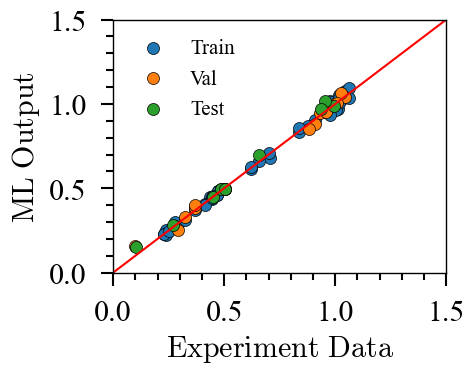

In [29]:
TargetPlotter = Plotters()
TargetPlotter.plot_model_eval(
            predictions={'train': train_predictions_transfer, 'test': test_predictions_transfer, 'val': val_predictions_transfer},
                        labels={'train': y_train_transfer.flatten(), 'test': y_test_transfer.flatten(), 'val': y_val_transfer.flatten()}, 
                        llimit=0, ulimit=1.5, fig_size=(5, 4),
                        name='model_eval', 
                        x_label = r'$\rm Experiment\ Data$',
                        y_label = r'$\rm ML \ Output$', save_fig=False, add_legend=True)

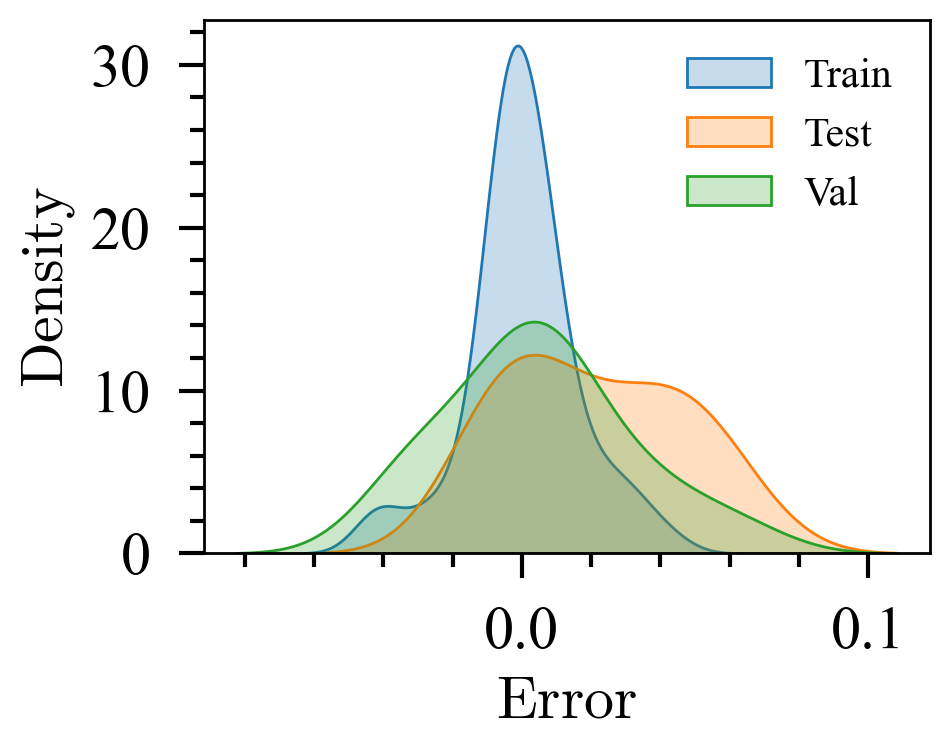

In [30]:
TargetPlotter.plot_pred_distribution(
        error_data={'train': y_train_transfer.flatten() - train_predictions_transfer,
                    'test': y_test_transfer.flatten() - test_predictions_transfer,
                    'val': y_val_transfer.flatten() - val_predictions_transfer},
        fig_size=(5, 4), save_fig=False, add_legend=False)

## 3 SHAP

In [74]:
import matplotlib.pyplot as plt

def disp_shap_bar(shap_values, data, title = 'EC', color = 'red', figsize=(6, 4)):

    # plot bar
    shap.summary_plot(shap_values, data, plot_type="bar", show=False, color=color)

    fig = plt.gcf()
    fig.set_size_inches(figsize)

    plt.rcParams['mathtext.fontset'] = 'cm'
    plt.rcParams["font.family"] = "serif"
    plt.rcParams["font.serif"] = ["Times New Roman"
                                            ] + plt.rcParams["font.serif"]
    plt.rcParams['font.size'] = 18
    plt.rcParams['figure.dpi'] = 100

    plt.title(title, fontsize=18)
    plt.xlabel(r'$ \rm Feature\ importance$', fontsize=18)

    # Increase tick label font sizes
    plt.tick_params(axis='both', which='major', labelsize=18)
    # Adjust layout to prevent cutting off labels
    plt.tight_layout()

    plt.show()

In [73]:
def disp_shap_beeswarm(shap_values, data, title='EC', figsize=(6, 4)):
    # plot bee swarm
    shap.summary_plot(shap_values, feature_names=data.columns, features=data, show=False)

    fig1 = plt.gcf()
    fig1.set_size_inches(figsize)

    plt.rcParams['mathtext.fontset'] = 'cm'
    plt.rcParams["font.family"] = "serif"
    plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]
    plt.rcParams['figure.dpi'] = 100
    
    # Increase font sizes
    plt.rcParams['font.size'] = 18  
    plt.title(title, fontsize=18) 
    plt.xlabel(r'$ \rm Feature\ importance$', fontsize=18)  # Larger x-label font
    
    # Increase tick label font sizes
    plt.tick_params(axis='both', which='major', labelsize=18)
    
    # Adjust layout to prevent cutting off labels
    plt.tight_layout()
    
    plt.show()

In [64]:
sim_data.columns[:-3]

Index(['Ecell', 'Dil', 'Conc', 'Ncell', 'T_tot', 'IEC_r', 'poros_r', 'dens_r',
       'dp'],
      dtype='object')

In [65]:
cols = [
        r'$ \rm E_{cell}$',
        r'$ \rm Conc_{Dil}$',
        r'$ \rm Conc_{Con}$',
        r'$ \rm N{cells}$',
        r'$ \rm Time_{total}$',
        r'$ \rm IEC_{RESIN}$',
        r'$ \rm \phi_{RESIN}$',
        r'$ \rm \rho_{RESIN}$',
        r'$ \rm dp_{RESIN}$']

In [66]:
# merge data
X_train_test_val = np.concatenate((X_train, X_test, X_val), axis=0)
X_train_test_val = X_train_test_val[np.random.choice(X_train_test_val.shape[0], 1000, replace=False)] # sample 1000 points

In [67]:
# merge data
evaluated_data_transfer = pd.DataFrame(X_train_test_val, columns=cols)
explainer_transfer = shap.DeepExplainer(TargetModel, X_train_test_val)
shap_values_transfer = explainer_transfer.shap_values(X_train_test_val)

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


##### Salt removal efficiency

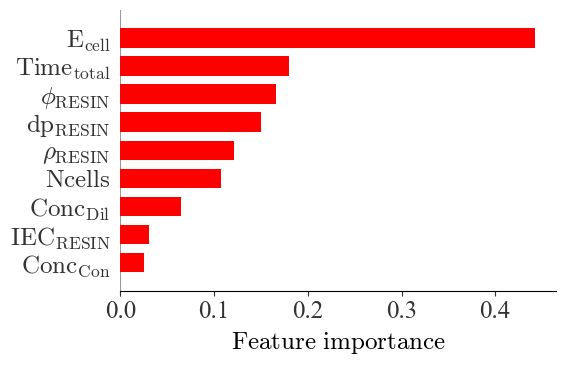

In [77]:
disp_shap_bar(shap_values=shap_values_transfer[0], data=evaluated_data_transfer, title = '', color = 'red')

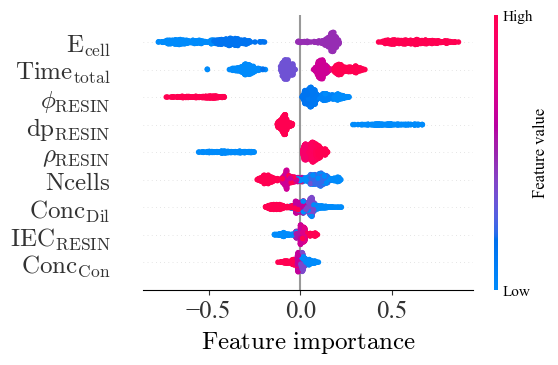

In [78]:
disp_shap_beeswarm(shap_values_transfer[0], evaluated_data_transfer, title = '')

##### Energy Consumed

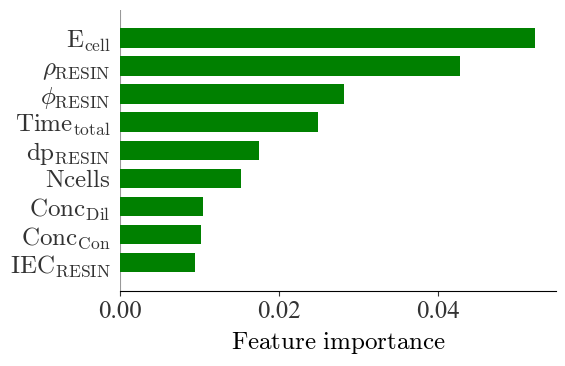

In [79]:
disp_shap_bar(shap_values_transfer[1], evaluated_data_transfer, title = '', color = 'green')

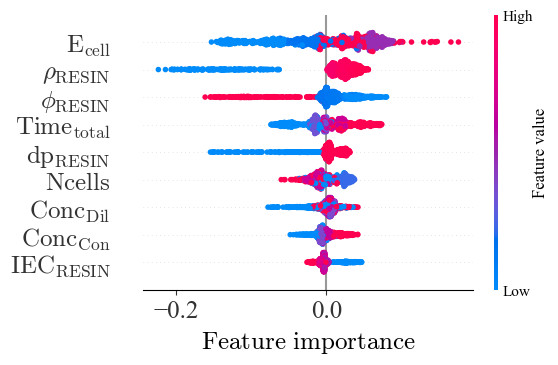

In [80]:
disp_shap_beeswarm(shap_values_transfer[1], evaluated_data_transfer, title = '')

##### Thermodynamics Efficiency

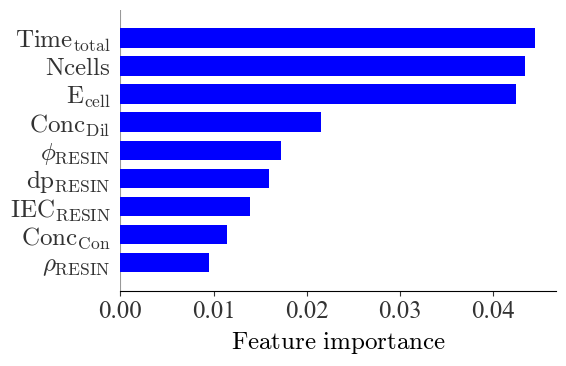

In [83]:
disp_shap_bar(shap_values_transfer[2], evaluated_data_transfer, title = '', color = 'blue')

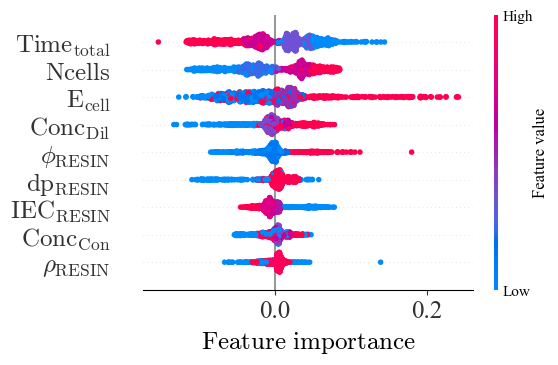

In [84]:
disp_shap_beeswarm(shap_values_transfer[2], evaluated_data_transfer, title = '')